In [99]:
import pandas as pd
from multiprocessing import Pool

import matplotlib.pyplot as plt

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit import Chem

from tqdm import tqdm

import numpy as np
from scipy.sparse import csr_matrix

from utils.RMT import RMTClassifier

import importlib
importlib.reload(RMT)

tqdm.pandas()

In [62]:
def clean_df(df, drop_non_binders = True):

    df_simple = df[['Molecule ChEMBL ID', 'Molecule Name',
                          'Uo Units', 'Ligand Efficiency BEI', 'Smiles',
                          'Standard Value', 'Standard Units']]

    df_simple['Standard Value'] = pd.to_numeric(df_simple['Standard Value'],
                                         errors = 'coerce')

    #df_simple = df_simple.dropna()
    df_simple = df_simple.reset_index(drop = True)

    #print(df_simple['Standard Units'].unique())
    
    df_simple = df_simple[df_simple['Standard Units'] == 'nM']

    
    df_simple = df_simple.dropna(subset = ['Smiles'])

    if drop_non_binders:
        df_simple = df_simple[df_simple['Standard Value'] < 1000]

    df_simple = df_simple.drop_duplicates(subset = 'Smiles',
                                          keep = 'first')
    
    return df_simple


def get_unfolded_fingerprint(smile):   
    
    compound = Chem.MolFromSmiles(smile)
    #fp       = Chem.\
    #            .FingerprintMols.FingerprintMol(compound, 2)
    
    #fp       = Chem.AllChem.\
    #           GetMorganFingerprintAsBitVect(compound,
    #                                        2, nBits = 2048)
    
    bi = {}
    #fp = Chem.AllChem.GetMorganFingerprint(compound, radius=1, bitInfo=bi)
            
    #fp       = Chem.AllChem.GetMorganFingerprint(compound, 2)
    
    fp        = Chem.UnfoldedRDKFingerprintCountBased(compound, minPath = 1)

    #fp       = Chem.RDKFingerprint(compound, maxPath = 10)

    return fp


def forrest_fingerprint(smile):
    
    
    # Obtain dictionary of fingerprints and order
    
    bi = {}
    Chem.AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smile), radius=1, bitInfo=bi)

    # Iterate over dictionary to store as pd.Series
    mol = pd.DataFrame()
    for key, value in bi.items():
        for i in range(len(value)):
            sub = pd.Series()
            sub['val'] = str(key)

            sub['order'] = value[i][0]
            sub['radius'] = value[i][1]

            mol = mol.append(sub, ignore_index=True)

    # Correctly order fingerprint
    mol = mol.sort_values(by=['order', 'radius']).reset_index(drop=True)

    # Convert ordered fingerprint into single string
    mol_string = " ".join(mol.val.tolist())
        
    return mol_string.strip()


def get_morgan_matrix(smile):
    
    compound = Chem.MolFromSmiles(smile)
    
    fp       = Chem.AllChem.\
               GetMorganFingerprintAsBitVect(compound,
                                            2, nBits = 2048)
    
    
    
    return [int(i) for i in fp]


def conv_rdkit_to_csr(rdkit_sparse):

    data = np.array(list(rdkit_sparse.GetNonzeroElements().values()))
    rows = np.array([0 for i in range(len(rdkit_sparse.GetNonzeroElements()))])
    columns = np.array(list(rdkit_sparse.GetNonzeroElements().keys()))
    
    return csr_matrix((data, (rows,columns)))

In [3]:
help(Chem.AllChem)

Help on module rdkit.Chem.AllChem in rdkit.Chem:

NAME
    rdkit.Chem.AllChem - Import all RDKit chemistry modules

FUNCTIONS
    AddHs(...)
        AddHs( (Mol)mol [, (bool)explicitOnly=False [, (bool)addCoords=False [, (AtomPairsParameters)onlyOnAtoms=None]]]) -> Mol :
            Adds hydrogens to the graph of a molecule.
            
              ARGUMENTS:
            
                - mol: the molecule to be modified
            
                - explicitOnly: (optional) if this toggle is set, only explicit Hs will
                  be added to the molecule.  Default value is 0 (add implicit and explicit Hs).
            
                - addCoords: (optional) if this toggle is set, The Hs will have 3D coordinates
                  set.  Default value is 0 (no 3D coords).
            
                - onlyOnHs: (optional) if this sequence is provided, only these atoms will be
                  considered to have Hs added to them
            
              RETURNS: a new mole

In [4]:
adrb = pd.read_csv('../data/ChemBL_ADRB1.csv', sep = ';')
ht1a = pd.read_csv('../data/ChemBL_5HT1A.csv', sep = ';')

clean_ardb = clean_df(adrb)
clean_ht1a = clean_df(ht1a, drop_non_binders = False)

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
p = Pool(6)

clean_ardb['Unfolded'] = p.map(get_unfolded_fingerprint, clean_ardb['Smiles'].tolist())
clean_ht1a['Unfolded'] = p.map(get_unfolded_fingerprint, clean_ht1a['Smiles'].tolist())

In [13]:
p = Pool(6)

clean_ardb['Morgan'] = p.map(get_morgan_matrix, clean_ardb['Smiles'].tolist())
clean_ht1a['Morgan'] = p.map(get_morgan_matrix, clean_ht1a['Smiles'].tolist())

In [6]:
clean_ardb['forrest_unfolded'] = clean_ardb['Smiles'].progress_apply(forrest_fingerprint)
clean_ardb['forrest_unfolded'] = clean_ht1a['Smiles'].progress_apply(forrest_fingerprint)

100%|██████████| 892/892 [03:41<00:00,  4.03it/s]


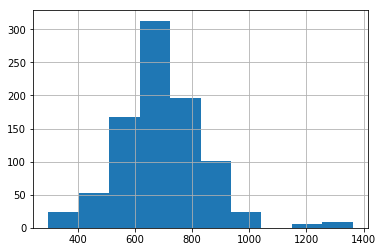

In [43]:
clean_ardb['forrest_unfolded'].apply(len).hist()

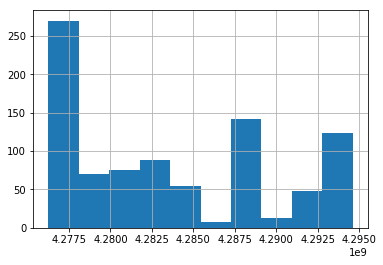

In [15]:
clean_ardb['Unfolded'].apply(lambda x: x.GetLength()).hist()


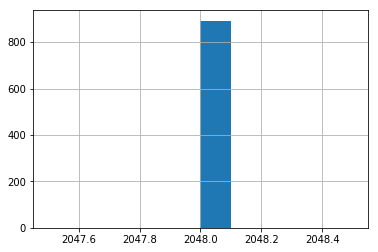

In [17]:
clean_ardb['Morgan'].apply(lambda x: len(x)).hist()

In [73]:
clean_ardb['Y'] = clean_ardb['Standard Value'].apply(lambda x: 0 if x < 1000 else 1)
clean_ht1a['Y'] = clean_ht1a['Standard Value'].apply(lambda x: 0 if x < 1000 else 1)

In [79]:
X_morgan = clean_ardb['Morgan'].append(clean_ht1a['Morgan'])
X_morgan = np.array([np.array(i) for i in X_train_morgan.values])

y_train_morgan = clean_ardb['Y'].append(clean_ht1a['Y'])

In [ ]:
X_train_morgan, X_test_morgan, \
y_train_morgan, y_test_morgan = train_test_split(X, y)

In [77]:
clean_ardb['Unfolded'] = clean_ardb['Unfolded'].apply(conv_rdkit_to_csr)
clean_ht1a['Unfolded'] = clean_ht1a['Unfolded'].apply(conv_rdkit_to_csr)

In [100]:
clf = RMTClassifier()
clf.fit(X_train_morgan, y_train_morgan)
test_preds = clf.predict(X_train_morgan, epsilon_multiple = 1)

print('confusion_matrix \n',confusion_matrix(y_test, test_preds))
print(classification_report(y_test,test_preds))

/miniconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


NameError: name 'X_test' is not defined

In [87]:
clf = RMTClassifier()
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test, epsilon_multiple = 1)

print('confusion_matrix \n',confusion_matrix(y_test, test_preds))
print(classification_report(y_test,test_preds))

NameError: name 'X_train' is not defined